In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.cluster import AffinityPropagation

from sklearn.metrics import accuracy_score

## Data import

We are working with a kaggle dataset, so we already have both a training and a testing set, we won't need to make our owns manually.

In [36]:
data_raw = pd.read_csv('./data/poker-hand-training.csv')
data_test_raw = pd.read_csv('./data/poker-hand-testing.csv')

In [37]:
data_raw.head()

,Suit of Card 1,Rank of Card 1,Suit of Card 2,Rank of Card 2,Suit of Card 3,Rank of Card 3,Suit of Card 4,Rank of Card 4,Suit of Card 5,Rank of Card 5,Poker Hand
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9


In [38]:
hands_map = {
    0 : 'Nothing in hand',
    1 : 'One pair',
    2 : 'Two pairs',
    3 : 'Three of a kind',
    4 : 'Straight',
    5 : 'Flush',
    6 : 'Full house',
    7 : 'Four of a kind',
    8 : 'Straight flush',
    9 : 'Royal flush'}

#### Distribution histograms

array([[<AxesSubplot:title={'center':'Suit of Card 1'}>,
        <AxesSubplot:title={'center':'Rank of Card 1'}>],
       [<AxesSubplot:title={'center':'Suit of Card 2'}>,
        <AxesSubplot:title={'center':'Rank of Card 2'}>],
       [<AxesSubplot:title={'center':'Suit of Card 3'}>,
        <AxesSubplot:title={'center':'Rank of Card 3'}>],
       [<AxesSubplot:title={'center':'Suit of Card 4'}>,
        <AxesSubplot:title={'center':'Rank of Card 4'}>],
       [<AxesSubplot:title={'center':'Suit of Card 5'}>,
        <AxesSubplot:title={'center':'Rank of Card 5'}>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

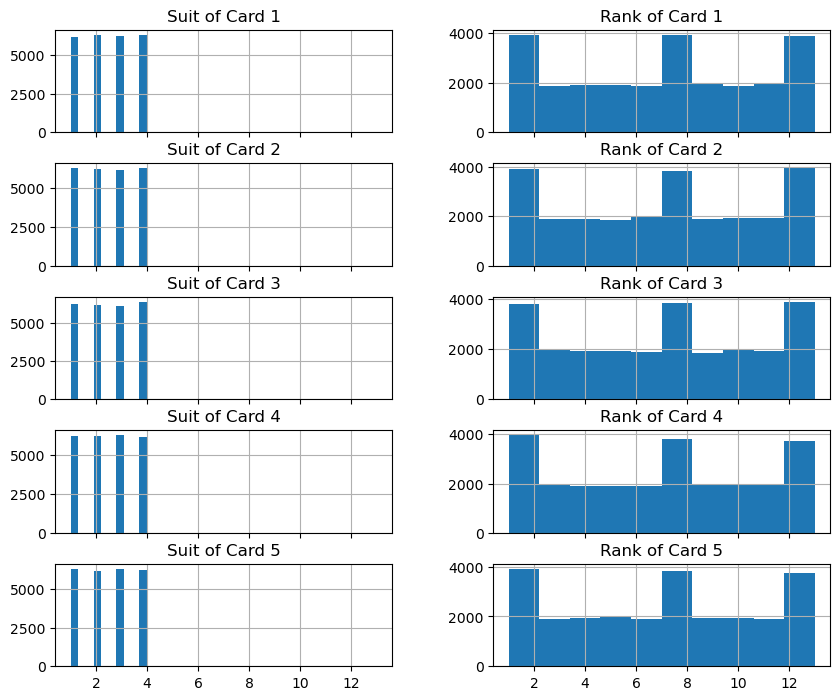

In [39]:
data_raw.drop(columns=['Poker Hand']).hist(sharex=True, figsize=(10,10), layout=(6,2))

<AxesSubplot:>

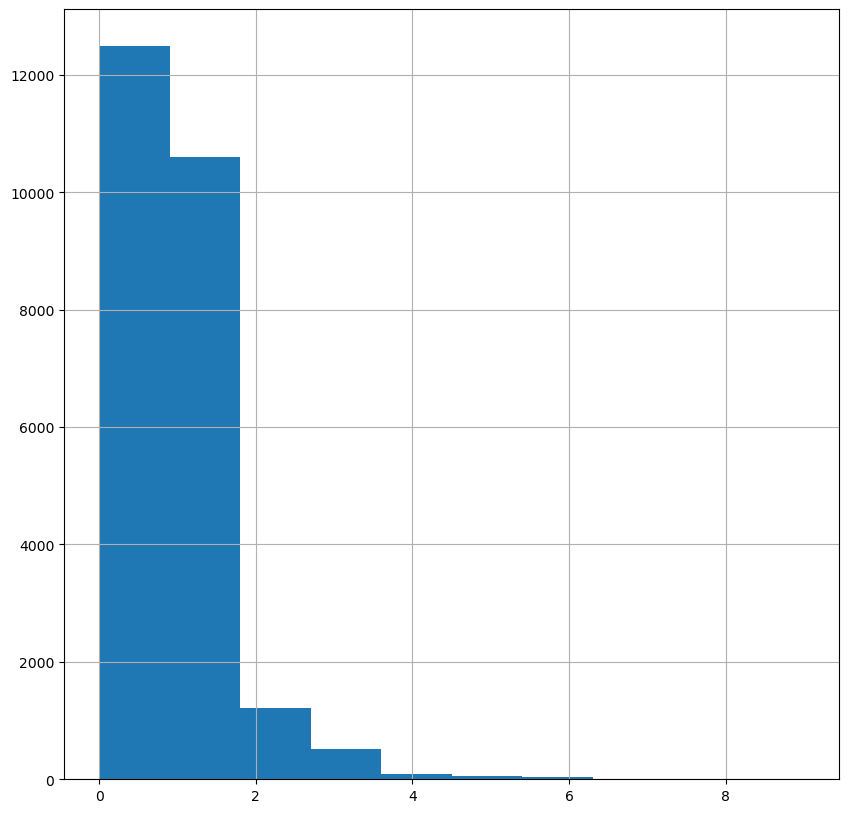

In [40]:
data_raw['Poker Hand'].hist(figsize=(10,10))

#### Correlation matrix

<AxesSubplot:>

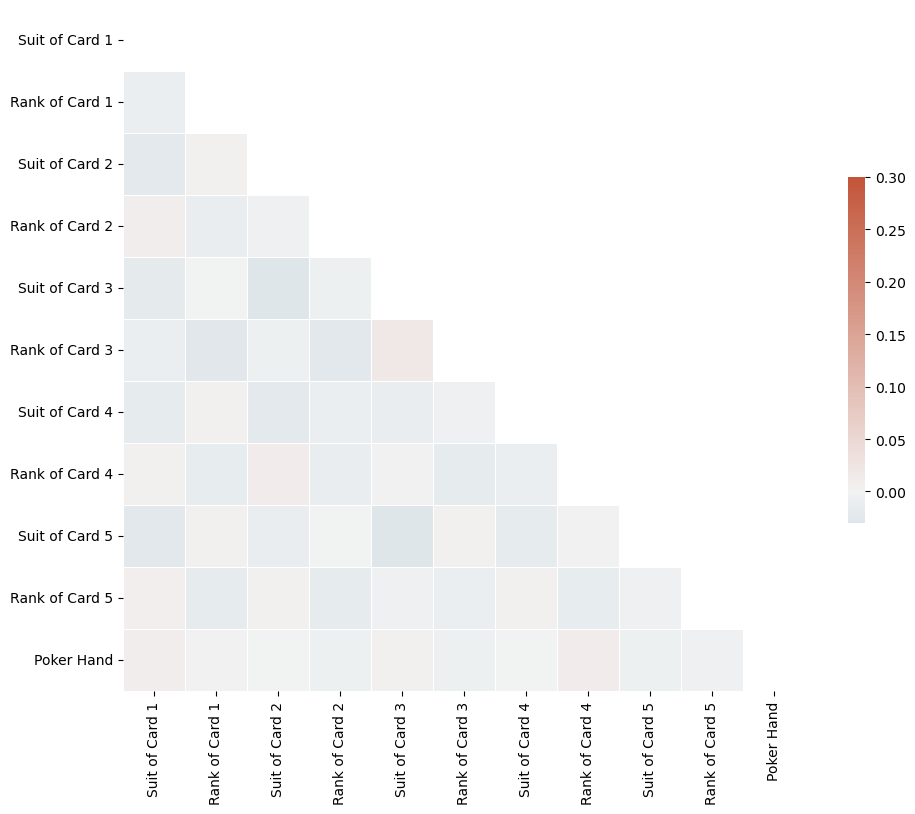

In [41]:
corr = data_raw.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In the following we'll be working with a reduced dataset because of a lack of RAM to handle the full dataset. We'll only use about 5% of the original dataset, which amounts to around 12000 individuals.
However we'll still be keeping the original proportions, as well as shuffling the data in the process.

In [42]:
X = data_raw.drop(columns=['Poker Hand'])
Y = data_raw['Poker Hand']

# We are using this function in a strange and roundabout way to obtain what we want but it works in the end

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=0)
for train_index, test_index in sss.split(X,Y):
    X, Y = X.iloc[test_index], Y.iloc[test_index]
data = data_raw.iloc[test_index]

#### 2D ACP Projection

In [43]:
acp = PCA()
if True:
    data_ = (data-data.mean(axis=0))/data.std(axis=0)
else:
    data_ = data
acp.fit(data_)
X_pca = acp.transform(data_)
del data_

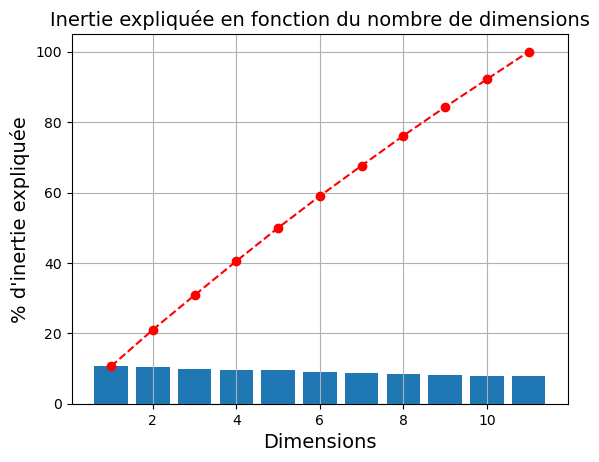

In [44]:
plt.bar(np.arange(len(acp.explained_variance_ratio_))+1,acp.explained_variance_ratio_*100)
plt.plot(np.arange(len(acp.explained_variance_ratio_))+1,np.cumsum(acp.explained_variance_ratio_*100),'r--o')
plt.xlabel("Dimensions",fontsize=14)
plt.ylabel("% d'inertie expliquée",fontsize=14)
plt.title("Inertie expliquée en fonction du nombre de dimensions",fontsize=14);
plt.grid(True)

Looking at the graph above, we can see that using an ACP on this problem will be uterly useless.

#### 2D TSNE Projection

In [45]:
if True:
    data_ = (data-data.mean(axis=0))/data.std(axis=0)
else:
    data_ = data
tsne = TSNE(n_components=2, init='random', random_state=0)
X_tsne = tsne.fit_transform(data_)

<function matplotlib.pyplot.show(close=None, block=None)>

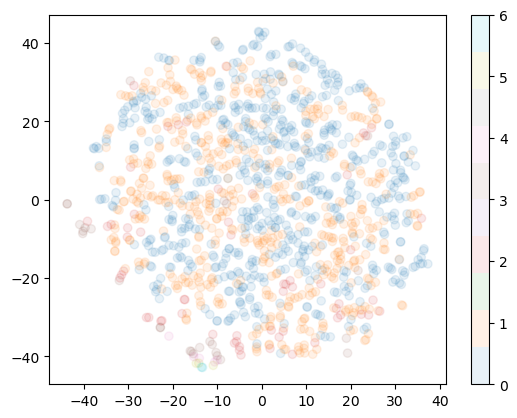

In [46]:
plt.scatter(X_tsne[:,0],X_tsne[:,1], c=data['Poker Hand'], cmap='tab10', alpha=0.1)
plt.colorbar()
plt.show

### il est possible que nous ayons à ne représenter qu'une partie des données pour que ce soit plus clair, auquel cas il faut faire attention à ce que toutes les classes soient représentées en proportions égales à celles du dataset d'origine.

## Classification

Since we have a training set, and a testing set, we need a third validation set in order to preperly evaluate the effects of hyperparameters on our algorithm, however, instead of creating this set artifically, we'll instead use a Cross Validation in order to get rid of the need of a testing set, and our separate testing data will become the validation dataset.

The Cross Validation we'll be using will be a StratifiedShuffleSplit. We chose this one especially because we think that it is important for the algorithm to have each class represented in each learning epoch. the shuffle aspect will help randomize the data, since we don't know how sorted it already is.

The two critical parameters we'll have to discuss will be the damping, and the preference.

The remaining hyperparameter we'll be discussing is the affinity. By default the affinity matrix is computed using the euclidian distance. However it is also possible to provide our algorithm with a pre-computed affinity matrix, using the Manhattan distance for example.

#### Algorithm training

In [75]:
damping = np.arange(0.5,1,0.1)
preference = np.array([-2500, -2000, -1500, -1000, -500, -1])
results_raw = []

for i,damping_ in enumerate(damping):
    res = []
    for j, preference_ in enumerate(preference):

        res_ = []
        classifier = AffinityPropagation(damping=damping_, random_state=0, preference=preference_)

        sss = StratifiedShuffleSplit(n_splits=3, test_size=0.5, random_state=0)

        for train_index, test_index in sss.split(X,Y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

            classifier.fit(X_train, Y_train)
            predicted_classes = classifier.predict(X_test)
            res_.append(accuracy_score(Y_test, predicted_classes))
        res.append(res_)
    results_raw.append(res)

In [76]:
results_raw

[[[0.18370607028753994, 0.19968051118210864, 0.2108626198083067],
  [0.134185303514377, 0.1645367412140575, 0.12619808306709265],
  [0.12300319488817892, 0.1501597444089457, 0.1501597444089457],
  [0.08466453674121406, 0.10383386581469649, 0.11980830670926518],
  [0.04952076677316294, 0.04952076677316294, 0.07188498402555911],
  [0.003194888178913738, 0.0, 0.003194888178913738]],
 [[0.18370607028753994, 0.18849840255591055, 0.19808306709265175],
  [0.1757188498402556, 0.16613418530351437, 0.1645367412140575],
  [0.13099041533546327, 0.08306709265175719, 0.14536741214057508],
  [0.10702875399361023, 0.09424920127795527, 0.08945686900958466],
  [0.06070287539936102, 0.04153354632587859, 0.06230031948881789],
  [0.003194888178913738, 0.0, 0.003194888178913738]],
 [[0.13738019169329074, 0.1869009584664537, 0.18849840255591055],
  [0.1645367412140575, 0.1645367412140575, 0.16293929712460065],
  [0.12939297124600638, 0.08945686900958466, 0.15175718849840256],
  [0.10543130990415335, 0.081469

In [77]:
results = []
for res in results_raw:
    temp = []
    for res_ in res:
        temp.append(np.mean(res_))
    results.append(temp)
results

[[0.19808306709265175,
  0.14164004259850904,
  0.14110756123535675,
  0.10276890308839191,
  0.056975505857294995,
  0.0021299254526091584],
 [0.1900958466453674,
  0.1687965921192758,
  0.11980830670926518,
  0.09691160809371673,
  0.05484558040468584,
  0.0021299254526091584],
 [0.170926517571885,
  0.16400425985090522,
  0.1235356762513312,
  0.097444089456869,
  0.060170394036208726,
  0.0021299254526091584],
 [0.17358892438764642,
  0.16719914802981894,
  0.13312034078807242,
  0.09637912673056442,
  0.061235356762513314,
  0.0021299254526091584],
 [0.17305644302449416,
  0.16400425985090522,
  0.12140575079872203,
  0.10596379126730565,
  0.06283280085197018,
  0.0021299254526091584]]

<function matplotlib.pyplot.show(close=None, block=None)>

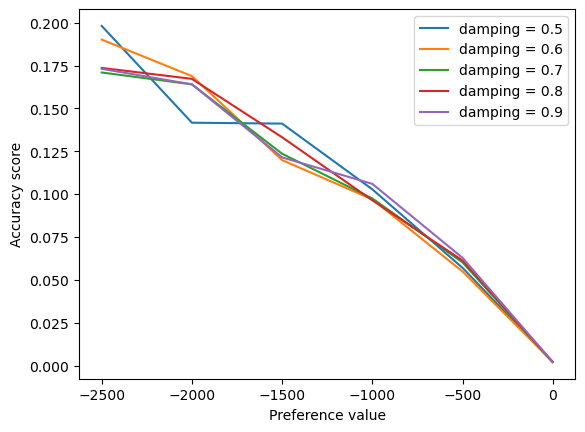

In [79]:
from cProfile import label


for i,res in enumerate(results):
    plt.plot([-2500, -2000, -1500, -1000, -500, -1], res, label='damping = '+str(round(damping[i], 1)))
plt.xlabel('Preference value')
plt.ylabel('Accuracy score')
plt.legend()
plt.show